# Architektur Neuronales Netz Demirer et al.

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import preprocessing


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.LayerNorm(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.ReLU(),
            nn.Linear(input_size, hidden1_size), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden 
            nn.ReLU(),
            nn.Dropout(p = 0.01),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): ReLU()
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.01, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#Bnorm = nn.BatchNorm1d(5)
T = log10(T)
p = p / 1000
# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
#x_input = Bnorm(x_input)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 1)

# Loss Funktion; gibt Fehler an
loss_fn = nn.MSELoss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 0.02
#learnin_rate = 1e-4
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
scheduler = MultiStepLR(optimizer, milestones=[30, 200], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
            #print(pred.size())
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 800 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/800, Iteration 1/12, Loss: 0.0139
Epoch 1/800, Iteration 2/12, Loss: 0.0074
Epoch 1/800, Iteration 3/12, Loss: 0.0082
Epoch 1/800, Iteration 4/12, Loss: 0.0088
Epoch 1/800, Iteration 5/12, Loss: 0.0084
Epoch 1/800, Iteration 6/12, Loss: 0.0063
Epoch 1/800, Iteration 7/12, Loss: 0.0068
Epoch 1/800, Iteration 8/12, Loss: 0.0060
Epoch 1/800, Iteration 9/12, Loss: 0.0071
Epoch 1/800, Iteration 10/12, Loss: 0.0095
Epoch 1/800, Iteration 11/12, Loss: 0.0045
Epoch 1/800, Iteration 12/12, Loss: 0.0073
Epoch 1/800, Iteration 13/12, Loss: 0.0050
Train Error: 
 Accuracy: 50.25%, Avg loss: 0.005971, MRE: 2.509959 

Test Error: 
 Accuracy: 43.0%, Avg loss: 0.006606, MRE: 3.075942 

Epoch 2/800, Iteration 1/12, Loss: 0.0059
Epoch 2/800, Iteration 2/12, Loss: 0.0072
Epoch 2/800, Iteration 3/12, Loss: 0.0053
Epoch 2/800, Iteration 4/12, Loss: 0.0043
Epoch 2/800, Iteration 5/12, Loss: 0.0043
Epoch 2/800, Iteration 6/12, Loss: 0.0057
Epoch 2/800, Iteration 7/12, Loss: 0.0049
Epoch 2/800, Iterati

Epoch 13/800, Iteration 5/12, Loss: 0.0019
Epoch 13/800, Iteration 6/12, Loss: 0.0018
Epoch 13/800, Iteration 7/12, Loss: 0.0018
Epoch 13/800, Iteration 8/12, Loss: 0.0013
Epoch 13/800, Iteration 9/12, Loss: 0.0010
Epoch 13/800, Iteration 10/12, Loss: 0.0020
Epoch 13/800, Iteration 11/12, Loss: 0.0017
Epoch 13/800, Iteration 12/12, Loss: 0.0019
Epoch 13/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 63.62%, Avg loss: 0.001377, MRE: 1.660016 

Test Error: 
 Accuracy: 58.5%, Avg loss: 0.001410, MRE: 2.665120 

Epoch 14/800, Iteration 1/12, Loss: 0.0014
Epoch 14/800, Iteration 2/12, Loss: 0.0024
Epoch 14/800, Iteration 3/12, Loss: 0.0017
Epoch 14/800, Iteration 4/12, Loss: 0.0015
Epoch 14/800, Iteration 5/12, Loss: 0.0016
Epoch 14/800, Iteration 6/12, Loss: 0.0015
Epoch 14/800, Iteration 7/12, Loss: 0.0013
Epoch 14/800, Iteration 8/12, Loss: 0.0016
Epoch 14/800, Iteration 9/12, Loss: 0.0014
Epoch 14/800, Iteration 10/12, Loss: 0.0012
Epoch 14/800, Iteration 11/12, Loss: 0.001

Train Error: 
 Accuracy: 63.75%, Avg loss: 0.001283, MRE: 1.627430 

Test Error: 
 Accuracy: 60.5%, Avg loss: 0.001203, MRE: 2.618004 

Epoch 26/800, Iteration 1/12, Loss: 0.0014
Epoch 26/800, Iteration 2/12, Loss: 0.0019
Epoch 26/800, Iteration 3/12, Loss: 0.0017
Epoch 26/800, Iteration 4/12, Loss: 0.0012
Epoch 26/800, Iteration 5/12, Loss: 0.0018
Epoch 26/800, Iteration 6/12, Loss: 0.0012
Epoch 26/800, Iteration 7/12, Loss: 0.0019
Epoch 26/800, Iteration 8/12, Loss: 0.0015
Epoch 26/800, Iteration 9/12, Loss: 0.0014
Epoch 26/800, Iteration 10/12, Loss: 0.0017
Epoch 26/800, Iteration 11/12, Loss: 0.0016
Epoch 26/800, Iteration 12/12, Loss: 0.0011
Epoch 26/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 57.25%, Avg loss: 0.001245, MRE: 1.605694 

Test Error: 
 Accuracy: 53.0%, Avg loss: 0.001234, MRE: 3.155133 

Epoch 27/800, Iteration 1/12, Loss: 0.0015
Epoch 27/800, Iteration 2/12, Loss: 0.0012
Epoch 27/800, Iteration 3/12, Loss: 0.0013
Epoch 27/800, Iteration 4/12, Loss: 

Test Error: 
 Accuracy: 52.5%, Avg loss: 0.001205, MRE: 3.076876 

Epoch 38/800, Iteration 1/12, Loss: 0.0016
Epoch 38/800, Iteration 2/12, Loss: 0.0014
Epoch 38/800, Iteration 3/12, Loss: 0.0021
Epoch 38/800, Iteration 4/12, Loss: 0.0013
Epoch 38/800, Iteration 5/12, Loss: 0.0012
Epoch 38/800, Iteration 6/12, Loss: 0.0012
Epoch 38/800, Iteration 7/12, Loss: 0.0019
Epoch 38/800, Iteration 8/12, Loss: 0.0013
Epoch 38/800, Iteration 9/12, Loss: 0.0015
Epoch 38/800, Iteration 10/12, Loss: 0.0016
Epoch 38/800, Iteration 11/12, Loss: 0.0015
Epoch 38/800, Iteration 12/12, Loss: 0.0017
Epoch 38/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 57.75%, Avg loss: 0.001241, MRE: 1.626849 

Test Error: 
 Accuracy: 52.5%, Avg loss: 0.001203, MRE: 3.065651 

Epoch 39/800, Iteration 1/12, Loss: 0.0014
Epoch 39/800, Iteration 2/12, Loss: 0.0015
Epoch 39/800, Iteration 3/12, Loss: 0.0014
Epoch 39/800, Iteration 4/12, Loss: 0.0016
Epoch 39/800, Iteration 5/12, Loss: 0.0015
Epoch 39/800, Itera

Epoch 49/800, Iteration 12/12, Loss: 0.0014
Epoch 49/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001240, MRE: 1.592966 

Test Error: 
 Accuracy: 53.0%, Avg loss: 0.001193, MRE: 3.002687 

Epoch 50/800, Iteration 1/12, Loss: 0.0015
Epoch 50/800, Iteration 2/12, Loss: 0.0017
Epoch 50/800, Iteration 3/12, Loss: 0.0013
Epoch 50/800, Iteration 4/12, Loss: 0.0014
Epoch 50/800, Iteration 5/12, Loss: 0.0017
Epoch 50/800, Iteration 6/12, Loss: 0.0015
Epoch 50/800, Iteration 7/12, Loss: 0.0018
Epoch 50/800, Iteration 8/12, Loss: 0.0016
Epoch 50/800, Iteration 9/12, Loss: 0.0021
Epoch 50/800, Iteration 10/12, Loss: 0.0015
Epoch 50/800, Iteration 11/12, Loss: 0.0014
Epoch 50/800, Iteration 12/12, Loss: 0.0012
Epoch 50/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001237, MRE: 1.603185 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001187, MRE: 2.931991 

Epoch 51/800, Iteration 1/12, Loss: 0.0016
Epoch 51/800, Iteration 2/12, Loss:

Epoch 62/800, Iteration 6/12, Loss: 0.0015
Epoch 62/800, Iteration 7/12, Loss: 0.0018
Epoch 62/800, Iteration 8/12, Loss: 0.0019
Epoch 62/800, Iteration 9/12, Loss: 0.0012
Epoch 62/800, Iteration 10/12, Loss: 0.0017
Epoch 62/800, Iteration 11/12, Loss: 0.0010
Epoch 62/800, Iteration 12/12, Loss: 0.0018
Epoch 62/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 58.13%, Avg loss: 0.001236, MRE: 1.612497 

Test Error: 
 Accuracy: 53.0%, Avg loss: 0.001192, MRE: 3.035778 

Epoch 63/800, Iteration 1/12, Loss: 0.0013
Epoch 63/800, Iteration 2/12, Loss: 0.0016
Epoch 63/800, Iteration 3/12, Loss: 0.0018
Epoch 63/800, Iteration 4/12, Loss: 0.0012
Epoch 63/800, Iteration 5/12, Loss: 0.0015
Epoch 63/800, Iteration 6/12, Loss: 0.0014
Epoch 63/800, Iteration 7/12, Loss: 0.0016
Epoch 63/800, Iteration 8/12, Loss: 0.0012
Epoch 63/800, Iteration 9/12, Loss: 0.0018
Epoch 63/800, Iteration 10/12, Loss: 0.0013
Epoch 63/800, Iteration 11/12, Loss: 0.0020
Epoch 63/800, Iteration 12/12, Loss: 0.00

Train Error: 
 Accuracy: 58.0%, Avg loss: 0.001227, MRE: 1.593414 

Test Error: 
 Accuracy: 52.5%, Avg loss: 0.001189, MRE: 3.030699 

Epoch 75/800, Iteration 1/12, Loss: 0.0016
Epoch 75/800, Iteration 2/12, Loss: 0.0015
Epoch 75/800, Iteration 3/12, Loss: 0.0017
Epoch 75/800, Iteration 4/12, Loss: 0.0013
Epoch 75/800, Iteration 5/12, Loss: 0.0014
Epoch 75/800, Iteration 6/12, Loss: 0.0011
Epoch 75/800, Iteration 7/12, Loss: 0.0016
Epoch 75/800, Iteration 8/12, Loss: 0.0019
Epoch 75/800, Iteration 9/12, Loss: 0.0017
Epoch 75/800, Iteration 10/12, Loss: 0.0020
Epoch 75/800, Iteration 11/12, Loss: 0.0014
Epoch 75/800, Iteration 12/12, Loss: 0.0015
Epoch 75/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001213, MRE: 1.595731 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001181, MRE: 2.945558 

Epoch 76/800, Iteration 1/12, Loss: 0.0013
Epoch 76/800, Iteration 2/12, Loss: 0.0012
Epoch 76/800, Iteration 3/12, Loss: 0.0012
Epoch 76/800, Iteration 4/12, Loss: 0

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001181, MRE: 2.954972 

Epoch 87/800, Iteration 1/12, Loss: 0.0018
Epoch 87/800, Iteration 2/12, Loss: 0.0013
Epoch 87/800, Iteration 3/12, Loss: 0.0012
Epoch 87/800, Iteration 4/12, Loss: 0.0015
Epoch 87/800, Iteration 5/12, Loss: 0.0016
Epoch 87/800, Iteration 6/12, Loss: 0.0019
Epoch 87/800, Iteration 7/12, Loss: 0.0014
Epoch 87/800, Iteration 8/12, Loss: 0.0016
Epoch 87/800, Iteration 9/12, Loss: 0.0014
Epoch 87/800, Iteration 10/12, Loss: 0.0015
Epoch 87/800, Iteration 11/12, Loss: 0.0013
Epoch 87/800, Iteration 12/12, Loss: 0.0014
Epoch 87/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 57.5%, Avg loss: 0.001236, MRE: 1.723704 

Test Error: 
 Accuracy: 52.5%, Avg loss: 0.001191, MRE: 3.061336 

Epoch 88/800, Iteration 1/12, Loss: 0.0014
Epoch 88/800, Iteration 2/12, Loss: 0.0017
Epoch 88/800, Iteration 3/12, Loss: 0.0012
Epoch 88/800, Iteration 4/12, Loss: 0.0017
Epoch 88/800, Iteration 5/12, Loss: 0.0010
Epoch 88/800, Iterat

Train Error: 
 Accuracy: 59.75%, Avg loss: 0.001208, MRE: 1.597931 

Test Error: 
 Accuracy: 55.5%, Avg loss: 0.001170, MRE: 2.835540 

Epoch 100/800, Iteration 1/12, Loss: 0.0017
Epoch 100/800, Iteration 2/12, Loss: 0.0015
Epoch 100/800, Iteration 3/12, Loss: 0.0015
Epoch 100/800, Iteration 4/12, Loss: 0.0015
Epoch 100/800, Iteration 5/12, Loss: 0.0014
Epoch 100/800, Iteration 6/12, Loss: 0.0018
Epoch 100/800, Iteration 7/12, Loss: 0.0014
Epoch 100/800, Iteration 8/12, Loss: 0.0013
Epoch 100/800, Iteration 9/12, Loss: 0.0015
Epoch 100/800, Iteration 10/12, Loss: 0.0020
Epoch 100/800, Iteration 11/12, Loss: 0.0015
Epoch 100/800, Iteration 12/12, Loss: 0.0015
Epoch 100/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001232, MRE: 1.583683 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001178, MRE: 2.954238 

Epoch 101/800, Iteration 1/12, Loss: 0.0018
Epoch 101/800, Iteration 2/12, Loss: 0.0012
Epoch 101/800, Iteration 3/12, Loss: 0.0013
Epoch 101/800, Itera

Epoch 112/800, Iteration 6/12, Loss: 0.0010
Epoch 112/800, Iteration 7/12, Loss: 0.0015
Epoch 112/800, Iteration 8/12, Loss: 0.0017
Epoch 112/800, Iteration 9/12, Loss: 0.0008
Epoch 112/800, Iteration 10/12, Loss: 0.0014
Epoch 112/800, Iteration 11/12, Loss: 0.0018
Epoch 112/800, Iteration 12/12, Loss: 0.0013
Epoch 112/800, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 56.38%, Avg loss: 0.001216, MRE: 1.597857 

Test Error: 
 Accuracy: 51.5%, Avg loss: 0.001195, MRE: 3.142856 

Epoch 113/800, Iteration 1/12, Loss: 0.0016
Epoch 113/800, Iteration 2/12, Loss: 0.0013
Epoch 113/800, Iteration 3/12, Loss: 0.0013
Epoch 113/800, Iteration 4/12, Loss: 0.0015
Epoch 113/800, Iteration 5/12, Loss: 0.0012
Epoch 113/800, Iteration 6/12, Loss: 0.0012
Epoch 113/800, Iteration 7/12, Loss: 0.0016
Epoch 113/800, Iteration 8/12, Loss: 0.0015
Epoch 113/800, Iteration 9/12, Loss: 0.0017
Epoch 113/800, Iteration 10/12, Loss: 0.0015
Epoch 113/800, Iteration 11/12, Loss: 0.0016
Epoch 113/800, Iterati

Train Error: 
 Accuracy: 57.0%, Avg loss: 0.001198, MRE: 1.586769 

Test Error: 
 Accuracy: 52.5%, Avg loss: 0.001181, MRE: 3.045912 

Epoch 125/800, Iteration 1/12, Loss: 0.0018
Epoch 125/800, Iteration 2/12, Loss: 0.0018
Epoch 125/800, Iteration 3/12, Loss: 0.0014
Epoch 125/800, Iteration 4/12, Loss: 0.0016
Epoch 125/800, Iteration 5/12, Loss: 0.0014
Epoch 125/800, Iteration 6/12, Loss: 0.0012
Epoch 125/800, Iteration 7/12, Loss: 0.0012
Epoch 125/800, Iteration 8/12, Loss: 0.0018
Epoch 125/800, Iteration 9/12, Loss: 0.0012
Epoch 125/800, Iteration 10/12, Loss: 0.0014
Epoch 125/800, Iteration 11/12, Loss: 0.0016
Epoch 125/800, Iteration 12/12, Loss: 0.0013
Epoch 125/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001247, MRE: 1.585567 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001168, MRE: 2.904922 

Epoch 126/800, Iteration 1/12, Loss: 0.0017
Epoch 126/800, Iteration 2/12, Loss: 0.0012
Epoch 126/800, Iteration 3/12, Loss: 0.0015
Epoch 126/800, Iterat

Epoch 137/800, Iteration 1/12, Loss: 0.0015
Epoch 137/800, Iteration 2/12, Loss: 0.0021
Epoch 137/800, Iteration 3/12, Loss: 0.0014
Epoch 137/800, Iteration 4/12, Loss: 0.0018
Epoch 137/800, Iteration 5/12, Loss: 0.0013
Epoch 137/800, Iteration 6/12, Loss: 0.0013
Epoch 137/800, Iteration 7/12, Loss: 0.0014
Epoch 137/800, Iteration 8/12, Loss: 0.0012
Epoch 137/800, Iteration 9/12, Loss: 0.0012
Epoch 137/800, Iteration 10/12, Loss: 0.0017
Epoch 137/800, Iteration 11/12, Loss: 0.0013
Epoch 137/800, Iteration 12/12, Loss: 0.0013
Epoch 137/800, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001223, MRE: 1.609709 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001164, MRE: 2.886470 

Epoch 138/800, Iteration 1/12, Loss: 0.0012
Epoch 138/800, Iteration 2/12, Loss: 0.0015
Epoch 138/800, Iteration 3/12, Loss: 0.0013
Epoch 138/800, Iteration 4/12, Loss: 0.0012
Epoch 138/800, Iteration 5/12, Loss: 0.0020
Epoch 138/800, Iteration 6/12, Loss: 0.0017
Epoch 138/800, Iteration

Epoch 148/800, Iteration 11/12, Loss: 0.0013
Epoch 148/800, Iteration 12/12, Loss: 0.0014
Epoch 148/800, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001211, MRE: 1.806849 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001165, MRE: 2.935392 

Epoch 149/800, Iteration 1/12, Loss: 0.0015
Epoch 149/800, Iteration 2/12, Loss: 0.0017
Epoch 149/800, Iteration 3/12, Loss: 0.0012
Epoch 149/800, Iteration 4/12, Loss: 0.0014
Epoch 149/800, Iteration 5/12, Loss: 0.0014
Epoch 149/800, Iteration 6/12, Loss: 0.0016
Epoch 149/800, Iteration 7/12, Loss: 0.0015
Epoch 149/800, Iteration 8/12, Loss: 0.0014
Epoch 149/800, Iteration 9/12, Loss: 0.0016
Epoch 149/800, Iteration 10/12, Loss: 0.0011
Epoch 149/800, Iteration 11/12, Loss: 0.0020
Epoch 149/800, Iteration 12/12, Loss: 0.0016
Epoch 149/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001239, MRE: 1.894329 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001164, MRE: 2.912041 

Epoch 150/800, It

Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001205, MRE: 1.625876 

Test Error: 
 Accuracy: 55.5%, Avg loss: 0.001158, MRE: 2.863173 

Epoch 161/800, Iteration 1/12, Loss: 0.0014
Epoch 161/800, Iteration 2/12, Loss: 0.0011
Epoch 161/800, Iteration 3/12, Loss: 0.0019
Epoch 161/800, Iteration 4/12, Loss: 0.0012
Epoch 161/800, Iteration 5/12, Loss: 0.0013
Epoch 161/800, Iteration 6/12, Loss: 0.0014
Epoch 161/800, Iteration 7/12, Loss: 0.0018
Epoch 161/800, Iteration 8/12, Loss: 0.0014
Epoch 161/800, Iteration 9/12, Loss: 0.0017
Epoch 161/800, Iteration 10/12, Loss: 0.0014
Epoch 161/800, Iteration 11/12, Loss: 0.0017
Epoch 161/800, Iteration 12/12, Loss: 0.0013
Epoch 161/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001227, MRE: 1.599400 

Test Error: 
 Accuracy: 55.0%, Avg loss: 0.001160, MRE: 2.885231 

Epoch 162/800, Iteration 1/12, Loss: 0.0013
Epoch 162/800, Iteration 2/12, Loss: 0.0016
Epoch 162/800, Iteration 3/12, Loss: 0.0014
Epoch 162/800, Itera

Epoch 173/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001219, MRE: 1.597852 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001161, MRE: 2.910794 

Epoch 174/800, Iteration 1/12, Loss: 0.0014
Epoch 174/800, Iteration 2/12, Loss: 0.0016
Epoch 174/800, Iteration 3/12, Loss: 0.0013
Epoch 174/800, Iteration 4/12, Loss: 0.0016
Epoch 174/800, Iteration 5/12, Loss: 0.0013
Epoch 174/800, Iteration 6/12, Loss: 0.0016
Epoch 174/800, Iteration 7/12, Loss: 0.0017
Epoch 174/800, Iteration 8/12, Loss: 0.0014
Epoch 174/800, Iteration 9/12, Loss: 0.0015
Epoch 174/800, Iteration 10/12, Loss: 0.0015
Epoch 174/800, Iteration 11/12, Loss: 0.0015
Epoch 174/800, Iteration 12/12, Loss: 0.0013
Epoch 174/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001209, MRE: 1.591016 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001161, MRE: 2.922730 

Epoch 175/800, Iteration 1/12, Loss: 0.0012
Epoch 175/800, Iteration 2/12, Loss: 0.0013
Epoch 175/800, Iter

Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001205, MRE: 1.733020 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001159, MRE: 2.900583 

Epoch 186/800, Iteration 1/12, Loss: 0.0011
Epoch 186/800, Iteration 2/12, Loss: 0.0016
Epoch 186/800, Iteration 3/12, Loss: 0.0013
Epoch 186/800, Iteration 4/12, Loss: 0.0013
Epoch 186/800, Iteration 5/12, Loss: 0.0010
Epoch 186/800, Iteration 6/12, Loss: 0.0018
Epoch 186/800, Iteration 7/12, Loss: 0.0016
Epoch 186/800, Iteration 8/12, Loss: 0.0016
Epoch 186/800, Iteration 9/12, Loss: 0.0014
Epoch 186/800, Iteration 10/12, Loss: 0.0012
Epoch 186/800, Iteration 11/12, Loss: 0.0015
Epoch 186/800, Iteration 12/12, Loss: 0.0012
Epoch 186/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001204, MRE: 1.580116 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001160, MRE: 2.917377 

Epoch 187/800, Iteration 1/12, Loss: 0.0016
Epoch 187/800, Iteration 2/12, Loss: 0.0013
Epoch 187/800, Iteration 3/12, Loss: 0.0009
Epoch 187/800, Itera

Train Error: 
 Accuracy: 58.13%, Avg loss: 0.001204, MRE: 1.873847 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001161, MRE: 2.939870 

Epoch 199/800, Iteration 1/12, Loss: 0.0010
Epoch 199/800, Iteration 2/12, Loss: 0.0016
Epoch 199/800, Iteration 3/12, Loss: 0.0017
Epoch 199/800, Iteration 4/12, Loss: 0.0016
Epoch 199/800, Iteration 5/12, Loss: 0.0013
Epoch 199/800, Iteration 6/12, Loss: 0.0014
Epoch 199/800, Iteration 7/12, Loss: 0.0012
Epoch 199/800, Iteration 8/12, Loss: 0.0019
Epoch 199/800, Iteration 9/12, Loss: 0.0013
Epoch 199/800, Iteration 10/12, Loss: 0.0018
Epoch 199/800, Iteration 11/12, Loss: 0.0012
Epoch 199/800, Iteration 12/12, Loss: 0.0012
Epoch 199/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001217, MRE: 1.594933 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001158, MRE: 2.919870 

Epoch 200/800, Iteration 1/12, Loss: 0.0012
Epoch 200/800, Iteration 2/12, Loss: 0.0014
Epoch 200/800, Iteration 3/12, Loss: 0.0015
Epoch 200/800, Itera

Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001198, MRE: 1.597476 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.907387 

Epoch 211/800, Iteration 1/12, Loss: 0.0019
Epoch 211/800, Iteration 2/12, Loss: 0.0017
Epoch 211/800, Iteration 3/12, Loss: 0.0014
Epoch 211/800, Iteration 4/12, Loss: 0.0016
Epoch 211/800, Iteration 5/12, Loss: 0.0016
Epoch 211/800, Iteration 6/12, Loss: 0.0012
Epoch 211/800, Iteration 7/12, Loss: 0.0011
Epoch 211/800, Iteration 8/12, Loss: 0.0012
Epoch 211/800, Iteration 9/12, Loss: 0.0011
Epoch 211/800, Iteration 10/12, Loss: 0.0017
Epoch 211/800, Iteration 11/12, Loss: 0.0017
Epoch 211/800, Iteration 12/12, Loss: 0.0016
Epoch 211/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001202, MRE: 1.574430 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.898053 

Epoch 212/800, Iteration 1/12, Loss: 0.0020
Epoch 212/800, Iteration 2/12, Loss: 0.0016
Epoch 212/800, Iteration 3/12, Loss: 0.0018
Epoch 212/800, Itera

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001158, MRE: 2.908625 

Epoch 223/800, Iteration 1/12, Loss: 0.0014
Epoch 223/800, Iteration 2/12, Loss: 0.0016
Epoch 223/800, Iteration 3/12, Loss: 0.0013
Epoch 223/800, Iteration 4/12, Loss: 0.0013
Epoch 223/800, Iteration 5/12, Loss: 0.0022
Epoch 223/800, Iteration 6/12, Loss: 0.0014
Epoch 223/800, Iteration 7/12, Loss: 0.0018
Epoch 223/800, Iteration 8/12, Loss: 0.0014
Epoch 223/800, Iteration 9/12, Loss: 0.0015
Epoch 223/800, Iteration 10/12, Loss: 0.0013
Epoch 223/800, Iteration 11/12, Loss: 0.0014
Epoch 223/800, Iteration 12/12, Loss: 0.0016
Epoch 223/800, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001200, MRE: 1.578090 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001158, MRE: 2.917295 

Epoch 224/800, Iteration 1/12, Loss: 0.0013
Epoch 224/800, Iteration 2/12, Loss: 0.0014
Epoch 224/800, Iteration 3/12, Loss: 0.0016
Epoch 224/800, Iteration 4/12, Loss: 0.0012
Epoch 224/800, Iteration 5/12, Loss: 0.0015
E

Epoch 235/800, Iteration 11/12, Loss: 0.0014
Epoch 235/800, Iteration 12/12, Loss: 0.0015
Epoch 235/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001201, MRE: 1.574884 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001156, MRE: 2.889832 

Epoch 236/800, Iteration 1/12, Loss: 0.0015
Epoch 236/800, Iteration 2/12, Loss: 0.0022
Epoch 236/800, Iteration 3/12, Loss: 0.0009
Epoch 236/800, Iteration 4/12, Loss: 0.0012
Epoch 236/800, Iteration 5/12, Loss: 0.0013
Epoch 236/800, Iteration 6/12, Loss: 0.0013
Epoch 236/800, Iteration 7/12, Loss: 0.0013
Epoch 236/800, Iteration 8/12, Loss: 0.0016
Epoch 236/800, Iteration 9/12, Loss: 0.0019
Epoch 236/800, Iteration 10/12, Loss: 0.0015
Epoch 236/800, Iteration 11/12, Loss: 0.0013
Epoch 236/800, Iteration 12/12, Loss: 0.0014
Epoch 236/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001209, MRE: 1.566439 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001156, MRE: 2.888280 

Epoch 237/800, It

Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001221, MRE: 1.578513 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.907897 

Epoch 248/800, Iteration 1/12, Loss: 0.0014
Epoch 248/800, Iteration 2/12, Loss: 0.0016
Epoch 248/800, Iteration 3/12, Loss: 0.0014
Epoch 248/800, Iteration 4/12, Loss: 0.0014
Epoch 248/800, Iteration 5/12, Loss: 0.0012
Epoch 248/800, Iteration 6/12, Loss: 0.0013
Epoch 248/800, Iteration 7/12, Loss: 0.0011
Epoch 248/800, Iteration 8/12, Loss: 0.0017
Epoch 248/800, Iteration 9/12, Loss: 0.0015
Epoch 248/800, Iteration 10/12, Loss: 0.0011
Epoch 248/800, Iteration 11/12, Loss: 0.0011
Epoch 248/800, Iteration 12/12, Loss: 0.0016
Epoch 248/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001219, MRE: 1.707233 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.906593 

Epoch 249/800, Iteration 1/12, Loss: 0.0021
Epoch 249/800, Iteration 2/12, Loss: 0.0012
Epoch 249/800, Iteration 3/12, Loss: 0.0015
Epoch 249/800, Itera

Epoch 259/800, Iteration 11/12, Loss: 0.0016
Epoch 259/800, Iteration 12/12, Loss: 0.0013
Epoch 259/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001221, MRE: 1.654005 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001158, MRE: 2.913882 

Epoch 260/800, Iteration 1/12, Loss: 0.0011
Epoch 260/800, Iteration 2/12, Loss: 0.0014
Epoch 260/800, Iteration 3/12, Loss: 0.0013
Epoch 260/800, Iteration 4/12, Loss: 0.0015
Epoch 260/800, Iteration 5/12, Loss: 0.0014
Epoch 260/800, Iteration 6/12, Loss: 0.0011
Epoch 260/800, Iteration 7/12, Loss: 0.0014
Epoch 260/800, Iteration 8/12, Loss: 0.0015
Epoch 260/800, Iteration 9/12, Loss: 0.0015
Epoch 260/800, Iteration 10/12, Loss: 0.0016
Epoch 260/800, Iteration 11/12, Loss: 0.0014
Epoch 260/800, Iteration 12/12, Loss: 0.0016
Epoch 260/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001212, MRE: 1.564560 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.904839 

Epoch 261/800, It

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.898662 

Epoch 272/800, Iteration 1/12, Loss: 0.0014
Epoch 272/800, Iteration 2/12, Loss: 0.0015
Epoch 272/800, Iteration 3/12, Loss: 0.0018
Epoch 272/800, Iteration 4/12, Loss: 0.0013
Epoch 272/800, Iteration 5/12, Loss: 0.0019
Epoch 272/800, Iteration 6/12, Loss: 0.0015
Epoch 272/800, Iteration 7/12, Loss: 0.0013
Epoch 272/800, Iteration 8/12, Loss: 0.0017
Epoch 272/800, Iteration 9/12, Loss: 0.0011
Epoch 272/800, Iteration 10/12, Loss: 0.0014
Epoch 272/800, Iteration 11/12, Loss: 0.0012
Epoch 272/800, Iteration 12/12, Loss: 0.0015
Epoch 272/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001216, MRE: 1.568134 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001156, MRE: 2.890625 

Epoch 273/800, Iteration 1/12, Loss: 0.0012
Epoch 273/800, Iteration 2/12, Loss: 0.0018
Epoch 273/800, Iteration 3/12, Loss: 0.0011
Epoch 273/800, Iteration 4/12, Loss: 0.0013
Epoch 273/800, Iteration 5/12, Loss: 0.0013
E

Epoch 284/800, Iteration 7/12, Loss: 0.0016
Epoch 284/800, Iteration 8/12, Loss: 0.0012
Epoch 284/800, Iteration 9/12, Loss: 0.0013
Epoch 284/800, Iteration 10/12, Loss: 0.0012
Epoch 284/800, Iteration 11/12, Loss: 0.0012
Epoch 284/800, Iteration 12/12, Loss: 0.0015
Epoch 284/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001200, MRE: 1.575890 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.899400 

Epoch 285/800, Iteration 1/12, Loss: 0.0014
Epoch 285/800, Iteration 2/12, Loss: 0.0013
Epoch 285/800, Iteration 3/12, Loss: 0.0015
Epoch 285/800, Iteration 4/12, Loss: 0.0015
Epoch 285/800, Iteration 5/12, Loss: 0.0019
Epoch 285/800, Iteration 6/12, Loss: 0.0014
Epoch 285/800, Iteration 7/12, Loss: 0.0018
Epoch 285/800, Iteration 8/12, Loss: 0.0012
Epoch 285/800, Iteration 9/12, Loss: 0.0012
Epoch 285/800, Iteration 10/12, Loss: 0.0017
Epoch 285/800, Iteration 11/12, Loss: 0.0013
Epoch 285/800, Iteration 12/12, Loss: 0.0020
Epoch 285/800, Iterat

Epoch 297/800, Iteration 1/12, Loss: 0.0013
Epoch 297/800, Iteration 2/12, Loss: 0.0017
Epoch 297/800, Iteration 3/12, Loss: 0.0017
Epoch 297/800, Iteration 4/12, Loss: 0.0015
Epoch 297/800, Iteration 5/12, Loss: 0.0012
Epoch 297/800, Iteration 6/12, Loss: 0.0011
Epoch 297/800, Iteration 7/12, Loss: 0.0013
Epoch 297/800, Iteration 8/12, Loss: 0.0015
Epoch 297/800, Iteration 9/12, Loss: 0.0012
Epoch 297/800, Iteration 10/12, Loss: 0.0014
Epoch 297/800, Iteration 11/12, Loss: 0.0017
Epoch 297/800, Iteration 12/12, Loss: 0.0013
Epoch 297/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001203, MRE: 1.559797 

Test Error: 
 Accuracy: 55.0%, Avg loss: 0.001154, MRE: 2.862136 

Epoch 298/800, Iteration 1/12, Loss: 0.0011
Epoch 298/800, Iteration 2/12, Loss: 0.0017
Epoch 298/800, Iteration 3/12, Loss: 0.0015
Epoch 298/800, Iteration 4/12, Loss: 0.0012
Epoch 298/800, Iteration 5/12, Loss: 0.0015
Epoch 298/800, Iteration 6/12, Loss: 0.0017
Epoch 298/800, Iteration

Epoch 309/800, Iteration 3/12, Loss: 0.0013
Epoch 309/800, Iteration 4/12, Loss: 0.0015
Epoch 309/800, Iteration 5/12, Loss: 0.0013
Epoch 309/800, Iteration 6/12, Loss: 0.0013
Epoch 309/800, Iteration 7/12, Loss: 0.0012
Epoch 309/800, Iteration 8/12, Loss: 0.0014
Epoch 309/800, Iteration 9/12, Loss: 0.0015
Epoch 309/800, Iteration 10/12, Loss: 0.0013
Epoch 309/800, Iteration 11/12, Loss: 0.0010
Epoch 309/800, Iteration 12/12, Loss: 0.0017
Epoch 309/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001187, MRE: 1.854447 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.881166 

Epoch 310/800, Iteration 1/12, Loss: 0.0013
Epoch 310/800, Iteration 2/12, Loss: 0.0016
Epoch 310/800, Iteration 3/12, Loss: 0.0015
Epoch 310/800, Iteration 4/12, Loss: 0.0013
Epoch 310/800, Iteration 5/12, Loss: 0.0013
Epoch 310/800, Iteration 6/12, Loss: 0.0016
Epoch 310/800, Iteration 7/12, Loss: 0.0016
Epoch 310/800, Iteration 8/12, Loss: 0.0015
Epoch 310/800, Iteration

Epoch 321/800, Iteration 4/12, Loss: 0.0019
Epoch 321/800, Iteration 5/12, Loss: 0.0013
Epoch 321/800, Iteration 6/12, Loss: 0.0013
Epoch 321/800, Iteration 7/12, Loss: 0.0011
Epoch 321/800, Iteration 8/12, Loss: 0.0020
Epoch 321/800, Iteration 9/12, Loss: 0.0014
Epoch 321/800, Iteration 10/12, Loss: 0.0012
Epoch 321/800, Iteration 11/12, Loss: 0.0018
Epoch 321/800, Iteration 12/12, Loss: 0.0016
Epoch 321/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001195, MRE: 1.564185 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.904683 

Epoch 322/800, Iteration 1/12, Loss: 0.0014
Epoch 322/800, Iteration 2/12, Loss: 0.0017
Epoch 322/800, Iteration 3/12, Loss: 0.0017
Epoch 322/800, Iteration 4/12, Loss: 0.0013
Epoch 322/800, Iteration 5/12, Loss: 0.0017
Epoch 322/800, Iteration 6/12, Loss: 0.0013
Epoch 322/800, Iteration 7/12, Loss: 0.0011
Epoch 322/800, Iteration 8/12, Loss: 0.0014
Epoch 322/800, Iteration 9/12, Loss: 0.0016
Epoch 322/800, Iteration

Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001208, MRE: 1.584877 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.908788 

Epoch 333/800, Iteration 1/12, Loss: 0.0016
Epoch 333/800, Iteration 2/12, Loss: 0.0015
Epoch 333/800, Iteration 3/12, Loss: 0.0008
Epoch 333/800, Iteration 4/12, Loss: 0.0012
Epoch 333/800, Iteration 5/12, Loss: 0.0013
Epoch 333/800, Iteration 6/12, Loss: 0.0014
Epoch 333/800, Iteration 7/12, Loss: 0.0012
Epoch 333/800, Iteration 8/12, Loss: 0.0014
Epoch 333/800, Iteration 9/12, Loss: 0.0014
Epoch 333/800, Iteration 10/12, Loss: 0.0015
Epoch 333/800, Iteration 11/12, Loss: 0.0014
Epoch 333/800, Iteration 12/12, Loss: 0.0014
Epoch 333/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001231, MRE: 1.567787 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.912983 

Epoch 334/800, Iteration 1/12, Loss: 0.0016
Epoch 334/800, Iteration 2/12, Loss: 0.0010
Epoch 334/800, Iteration 3/12, Loss: 0.0014
Epoch 334/800, Itera

Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001221, MRE: 1.583537 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.891873 

Epoch 345/800, Iteration 1/12, Loss: 0.0015
Epoch 345/800, Iteration 2/12, Loss: 0.0014
Epoch 345/800, Iteration 3/12, Loss: 0.0009
Epoch 345/800, Iteration 4/12, Loss: 0.0017
Epoch 345/800, Iteration 5/12, Loss: 0.0016
Epoch 345/800, Iteration 6/12, Loss: 0.0014
Epoch 345/800, Iteration 7/12, Loss: 0.0011
Epoch 345/800, Iteration 8/12, Loss: 0.0011
Epoch 345/800, Iteration 9/12, Loss: 0.0012
Epoch 345/800, Iteration 10/12, Loss: 0.0018
Epoch 345/800, Iteration 11/12, Loss: 0.0014
Epoch 345/800, Iteration 12/12, Loss: 0.0016
Epoch 345/800, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001205, MRE: 1.628212 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.891660 

Epoch 346/800, Iteration 1/12, Loss: 0.0013
Epoch 346/800, Iteration 2/12, Loss: 0.0015
Epoch 346/800, Iteration 3/12, Loss: 0.0016
Epoch 346/800, Itera

Epoch 357/800, Iteration 8/12, Loss: 0.0014
Epoch 357/800, Iteration 9/12, Loss: 0.0009
Epoch 357/800, Iteration 10/12, Loss: 0.0019
Epoch 357/800, Iteration 11/12, Loss: 0.0015
Epoch 357/800, Iteration 12/12, Loss: 0.0017
Epoch 357/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001206, MRE: 1.571846 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.908063 

Epoch 358/800, Iteration 1/12, Loss: 0.0013
Epoch 358/800, Iteration 2/12, Loss: 0.0013
Epoch 358/800, Iteration 3/12, Loss: 0.0014
Epoch 358/800, Iteration 4/12, Loss: 0.0014
Epoch 358/800, Iteration 5/12, Loss: 0.0016
Epoch 358/800, Iteration 6/12, Loss: 0.0014
Epoch 358/800, Iteration 7/12, Loss: 0.0016
Epoch 358/800, Iteration 8/12, Loss: 0.0014
Epoch 358/800, Iteration 9/12, Loss: 0.0011
Epoch 358/800, Iteration 10/12, Loss: 0.0016
Epoch 358/800, Iteration 11/12, Loss: 0.0016
Epoch 358/800, Iteration 12/12, Loss: 0.0012
Epoch 358/800, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accur

Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001210, MRE: 1.867725 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001157, MRE: 2.910819 

Epoch 370/800, Iteration 1/12, Loss: 0.0012
Epoch 370/800, Iteration 2/12, Loss: 0.0016
Epoch 370/800, Iteration 3/12, Loss: 0.0015
Epoch 370/800, Iteration 4/12, Loss: 0.0017
Epoch 370/800, Iteration 5/12, Loss: 0.0014
Epoch 370/800, Iteration 6/12, Loss: 0.0017
Epoch 370/800, Iteration 7/12, Loss: 0.0012
Epoch 370/800, Iteration 8/12, Loss: 0.0016
Epoch 370/800, Iteration 9/12, Loss: 0.0011
Epoch 370/800, Iteration 10/12, Loss: 0.0019
Epoch 370/800, Iteration 11/12, Loss: 0.0014
Epoch 370/800, Iteration 12/12, Loss: 0.0013
Epoch 370/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001201, MRE: 1.569181 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001156, MRE: 2.899507 

Epoch 371/800, Iteration 1/12, Loss: 0.0012
Epoch 371/800, Iteration 2/12, Loss: 0.0013
Epoch 371/800, Iteration 3/12, Loss: 0.0017
Epoch 371/800, Itera

Epoch 382/800, Iteration 2/12, Loss: 0.0011
Epoch 382/800, Iteration 3/12, Loss: 0.0014
Epoch 382/800, Iteration 4/12, Loss: 0.0012
Epoch 382/800, Iteration 5/12, Loss: 0.0018
Epoch 382/800, Iteration 6/12, Loss: 0.0014
Epoch 382/800, Iteration 7/12, Loss: 0.0011
Epoch 382/800, Iteration 8/12, Loss: 0.0018
Epoch 382/800, Iteration 9/12, Loss: 0.0012
Epoch 382/800, Iteration 10/12, Loss: 0.0013
Epoch 382/800, Iteration 11/12, Loss: 0.0015
Epoch 382/800, Iteration 12/12, Loss: 0.0015
Epoch 382/800, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001194, MRE: 1.567885 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.885556 

Epoch 383/800, Iteration 1/12, Loss: 0.0012
Epoch 383/800, Iteration 2/12, Loss: 0.0014
Epoch 383/800, Iteration 3/12, Loss: 0.0016
Epoch 383/800, Iteration 4/12, Loss: 0.0015
Epoch 383/800, Iteration 5/12, Loss: 0.0014
Epoch 383/800, Iteration 6/12, Loss: 0.0015
Epoch 383/800, Iteration 7/12, Loss: 0.0015
Epoch 383/800, Iteration

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.894905 

Epoch 394/800, Iteration 1/12, Loss: 0.0014
Epoch 394/800, Iteration 2/12, Loss: 0.0014
Epoch 394/800, Iteration 3/12, Loss: 0.0014
Epoch 394/800, Iteration 4/12, Loss: 0.0015
Epoch 394/800, Iteration 5/12, Loss: 0.0013
Epoch 394/800, Iteration 6/12, Loss: 0.0019
Epoch 394/800, Iteration 7/12, Loss: 0.0014
Epoch 394/800, Iteration 8/12, Loss: 0.0015
Epoch 394/800, Iteration 9/12, Loss: 0.0014
Epoch 394/800, Iteration 10/12, Loss: 0.0012
Epoch 394/800, Iteration 11/12, Loss: 0.0011
Epoch 394/800, Iteration 12/12, Loss: 0.0016
Epoch 394/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001218, MRE: 1.565164 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.891045 

Epoch 395/800, Iteration 1/12, Loss: 0.0014
Epoch 395/800, Iteration 2/12, Loss: 0.0018
Epoch 395/800, Iteration 3/12, Loss: 0.0013
Epoch 395/800, Iteration 4/12, Loss: 0.0020
Epoch 395/800, Iteration 5/12, Loss: 0.0010
E

Epoch 406/800, Iteration 11/12, Loss: 0.0013
Epoch 406/800, Iteration 12/12, Loss: 0.0017
Epoch 406/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001202, MRE: 1.560729 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.889910 

Epoch 407/800, Iteration 1/12, Loss: 0.0014
Epoch 407/800, Iteration 2/12, Loss: 0.0011
Epoch 407/800, Iteration 3/12, Loss: 0.0013
Epoch 407/800, Iteration 4/12, Loss: 0.0015
Epoch 407/800, Iteration 5/12, Loss: 0.0017
Epoch 407/800, Iteration 6/12, Loss: 0.0013
Epoch 407/800, Iteration 7/12, Loss: 0.0016
Epoch 407/800, Iteration 8/12, Loss: 0.0015
Epoch 407/800, Iteration 9/12, Loss: 0.0014
Epoch 407/800, Iteration 10/12, Loss: 0.0013
Epoch 407/800, Iteration 11/12, Loss: 0.0018
Epoch 407/800, Iteration 12/12, Loss: 0.0014
Epoch 407/800, Iteration 13/12, Loss: 0.0006
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001198, MRE: 1.574042 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001154, MRE: 2.882910 

Epoch 408/800, It

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.891252 

Epoch 419/800, Iteration 1/12, Loss: 0.0012
Epoch 419/800, Iteration 2/12, Loss: 0.0011
Epoch 419/800, Iteration 3/12, Loss: 0.0013
Epoch 419/800, Iteration 4/12, Loss: 0.0019
Epoch 419/800, Iteration 5/12, Loss: 0.0018
Epoch 419/800, Iteration 6/12, Loss: 0.0013
Epoch 419/800, Iteration 7/12, Loss: 0.0017
Epoch 419/800, Iteration 8/12, Loss: 0.0011
Epoch 419/800, Iteration 9/12, Loss: 0.0016
Epoch 419/800, Iteration 10/12, Loss: 0.0015
Epoch 419/800, Iteration 11/12, Loss: 0.0014
Epoch 419/800, Iteration 12/12, Loss: 0.0011
Epoch 419/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001199, MRE: 1.580979 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.895737 

Epoch 420/800, Iteration 1/12, Loss: 0.0016
Epoch 420/800, Iteration 2/12, Loss: 0.0015
Epoch 420/800, Iteration 3/12, Loss: 0.0015
Epoch 420/800, Iteration 4/12, Loss: 0.0013
Epoch 420/800, Iteration 5/12, Loss: 0.0012
E

Epoch 431/800, Iteration 8/12, Loss: 0.0014
Epoch 431/800, Iteration 9/12, Loss: 0.0013
Epoch 431/800, Iteration 10/12, Loss: 0.0016
Epoch 431/800, Iteration 11/12, Loss: 0.0016
Epoch 431/800, Iteration 12/12, Loss: 0.0013
Epoch 431/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001201, MRE: 1.572992 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001154, MRE: 2.877694 

Epoch 432/800, Iteration 1/12, Loss: 0.0015
Epoch 432/800, Iteration 2/12, Loss: 0.0011
Epoch 432/800, Iteration 3/12, Loss: 0.0011
Epoch 432/800, Iteration 4/12, Loss: 0.0016
Epoch 432/800, Iteration 5/12, Loss: 0.0015
Epoch 432/800, Iteration 6/12, Loss: 0.0016
Epoch 432/800, Iteration 7/12, Loss: 0.0015
Epoch 432/800, Iteration 8/12, Loss: 0.0014
Epoch 432/800, Iteration 9/12, Loss: 0.0013
Epoch 432/800, Iteration 10/12, Loss: 0.0018
Epoch 432/800, Iteration 11/12, Loss: 0.0012
Epoch 432/800, Iteration 12/12, Loss: 0.0013
Epoch 432/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accur

Epoch 443/800, Iteration 10/12, Loss: 0.0018
Epoch 443/800, Iteration 11/12, Loss: 0.0014
Epoch 443/800, Iteration 12/12, Loss: 0.0015
Epoch 443/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001186, MRE: 1.670987 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.897020 

Epoch 444/800, Iteration 1/12, Loss: 0.0016
Epoch 444/800, Iteration 2/12, Loss: 0.0016
Epoch 444/800, Iteration 3/12, Loss: 0.0015
Epoch 444/800, Iteration 4/12, Loss: 0.0016
Epoch 444/800, Iteration 5/12, Loss: 0.0015
Epoch 444/800, Iteration 6/12, Loss: 0.0013
Epoch 444/800, Iteration 7/12, Loss: 0.0010
Epoch 444/800, Iteration 8/12, Loss: 0.0011
Epoch 444/800, Iteration 9/12, Loss: 0.0019
Epoch 444/800, Iteration 10/12, Loss: 0.0013
Epoch 444/800, Iteration 11/12, Loss: 0.0015
Epoch 444/800, Iteration 12/12, Loss: 0.0014
Epoch 444/800, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001197, MRE: 1.569429 

Test Error: 
 Accuracy: 54.5%, Avg loss

Epoch 455/800, Iteration 8/12, Loss: 0.0014
Epoch 455/800, Iteration 9/12, Loss: 0.0012
Epoch 455/800, Iteration 10/12, Loss: 0.0015
Epoch 455/800, Iteration 11/12, Loss: 0.0012
Epoch 455/800, Iteration 12/12, Loss: 0.0013
Epoch 455/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001225, MRE: 1.569867 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001156, MRE: 2.901552 

Epoch 456/800, Iteration 1/12, Loss: 0.0015
Epoch 456/800, Iteration 2/12, Loss: 0.0014
Epoch 456/800, Iteration 3/12, Loss: 0.0015
Epoch 456/800, Iteration 4/12, Loss: 0.0016
Epoch 456/800, Iteration 5/12, Loss: 0.0012
Epoch 456/800, Iteration 6/12, Loss: 0.0014
Epoch 456/800, Iteration 7/12, Loss: 0.0013
Epoch 456/800, Iteration 8/12, Loss: 0.0017
Epoch 456/800, Iteration 9/12, Loss: 0.0014
Epoch 456/800, Iteration 10/12, Loss: 0.0013
Epoch 456/800, Iteration 11/12, Loss: 0.0016
Epoch 456/800, Iteration 12/12, Loss: 0.0012
Epoch 456/800, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accur

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001154, MRE: 2.877797 

Epoch 468/800, Iteration 1/12, Loss: 0.0012
Epoch 468/800, Iteration 2/12, Loss: 0.0016
Epoch 468/800, Iteration 3/12, Loss: 0.0011
Epoch 468/800, Iteration 4/12, Loss: 0.0013
Epoch 468/800, Iteration 5/12, Loss: 0.0014
Epoch 468/800, Iteration 6/12, Loss: 0.0016
Epoch 468/800, Iteration 7/12, Loss: 0.0016
Epoch 468/800, Iteration 8/12, Loss: 0.0014
Epoch 468/800, Iteration 9/12, Loss: 0.0019
Epoch 468/800, Iteration 10/12, Loss: 0.0017
Epoch 468/800, Iteration 11/12, Loss: 0.0015
Epoch 468/800, Iteration 12/12, Loss: 0.0013
Epoch 468/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001222, MRE: 1.564804 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001154, MRE: 2.887605 

Epoch 469/800, Iteration 1/12, Loss: 0.0019
Epoch 469/800, Iteration 2/12, Loss: 0.0015
Epoch 469/800, Iteration 3/12, Loss: 0.0014
Epoch 469/800, Iteration 4/12, Loss: 0.0015
Epoch 469/800, Iteration 5/12, Loss: 0.0013
E

Epoch 480/800, Iteration 1/12, Loss: 0.0010
Epoch 480/800, Iteration 2/12, Loss: 0.0019
Epoch 480/800, Iteration 3/12, Loss: 0.0016
Epoch 480/800, Iteration 4/12, Loss: 0.0017
Epoch 480/800, Iteration 5/12, Loss: 0.0014
Epoch 480/800, Iteration 6/12, Loss: 0.0018
Epoch 480/800, Iteration 7/12, Loss: 0.0016
Epoch 480/800, Iteration 8/12, Loss: 0.0009
Epoch 480/800, Iteration 9/12, Loss: 0.0016
Epoch 480/800, Iteration 10/12, Loss: 0.0018
Epoch 480/800, Iteration 11/12, Loss: 0.0015
Epoch 480/800, Iteration 12/12, Loss: 0.0014
Epoch 480/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001211, MRE: 1.586855 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.895090 

Epoch 481/800, Iteration 1/12, Loss: 0.0016
Epoch 481/800, Iteration 2/12, Loss: 0.0016
Epoch 481/800, Iteration 3/12, Loss: 0.0012
Epoch 481/800, Iteration 4/12, Loss: 0.0013
Epoch 481/800, Iteration 5/12, Loss: 0.0013
Epoch 481/800, Iteration 6/12, Loss: 0.0013
Epoch 481/800, Iteration

Epoch 492/800, Iteration 6/12, Loss: 0.0016
Epoch 492/800, Iteration 7/12, Loss: 0.0013
Epoch 492/800, Iteration 8/12, Loss: 0.0013
Epoch 492/800, Iteration 9/12, Loss: 0.0019
Epoch 492/800, Iteration 10/12, Loss: 0.0011
Epoch 492/800, Iteration 11/12, Loss: 0.0016
Epoch 492/800, Iteration 12/12, Loss: 0.0015
Epoch 492/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001222, MRE: 1.574675 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001154, MRE: 2.884237 

Epoch 493/800, Iteration 1/12, Loss: 0.0015
Epoch 493/800, Iteration 2/12, Loss: 0.0012
Epoch 493/800, Iteration 3/12, Loss: 0.0016
Epoch 493/800, Iteration 4/12, Loss: 0.0015
Epoch 493/800, Iteration 5/12, Loss: 0.0014
Epoch 493/800, Iteration 6/12, Loss: 0.0012
Epoch 493/800, Iteration 7/12, Loss: 0.0013
Epoch 493/800, Iteration 8/12, Loss: 0.0017
Epoch 493/800, Iteration 9/12, Loss: 0.0011
Epoch 493/800, Iteration 10/12, Loss: 0.0018
Epoch 493/800, Iteration 11/12, Loss: 0.0017
Epoch 493/800, Iterati

Epoch 505/800, Iteration 5/12, Loss: 0.0014
Epoch 505/800, Iteration 6/12, Loss: 0.0015
Epoch 505/800, Iteration 7/12, Loss: 0.0014
Epoch 505/800, Iteration 8/12, Loss: 0.0014
Epoch 505/800, Iteration 9/12, Loss: 0.0016
Epoch 505/800, Iteration 10/12, Loss: 0.0020
Epoch 505/800, Iteration 11/12, Loss: 0.0010
Epoch 505/800, Iteration 12/12, Loss: 0.0017
Epoch 505/800, Iteration 13/12, Loss: 0.0009
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001191, MRE: 1.576472 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001153, MRE: 2.872877 

Epoch 506/800, Iteration 1/12, Loss: 0.0011
Epoch 506/800, Iteration 2/12, Loss: 0.0017
Epoch 506/800, Iteration 3/12, Loss: 0.0013
Epoch 506/800, Iteration 4/12, Loss: 0.0015
Epoch 506/800, Iteration 5/12, Loss: 0.0012
Epoch 506/800, Iteration 6/12, Loss: 0.0012
Epoch 506/800, Iteration 7/12, Loss: 0.0015
Epoch 506/800, Iteration 8/12, Loss: 0.0016
Epoch 506/800, Iteration 9/12, Loss: 0.0015
Epoch 506/800, Iteration 10/12, Loss: 0.0013
Epoch 506/800, Iteratio

Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001205, MRE: 1.575732 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001154, MRE: 2.889175 

Epoch 518/800, Iteration 1/12, Loss: 0.0012
Epoch 518/800, Iteration 2/12, Loss: 0.0013
Epoch 518/800, Iteration 3/12, Loss: 0.0017
Epoch 518/800, Iteration 4/12, Loss: 0.0010
Epoch 518/800, Iteration 5/12, Loss: 0.0011
Epoch 518/800, Iteration 6/12, Loss: 0.0011
Epoch 518/800, Iteration 7/12, Loss: 0.0014
Epoch 518/800, Iteration 8/12, Loss: 0.0014
Epoch 518/800, Iteration 9/12, Loss: 0.0013
Epoch 518/800, Iteration 10/12, Loss: 0.0017
Epoch 518/800, Iteration 11/12, Loss: 0.0013
Epoch 518/800, Iteration 12/12, Loss: 0.0023
Epoch 518/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001195, MRE: 1.574556 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001155, MRE: 2.893614 

Epoch 519/800, Iteration 1/12, Loss: 0.0013
Epoch 519/800, Iteration 2/12, Loss: 0.0013
Epoch 519/800, Iteration 3/12, Loss: 0.0017
Epoch 519/800, Itera

Epoch 529/800, Iteration 10/12, Loss: 0.0011
Epoch 529/800, Iteration 11/12, Loss: 0.0016
Epoch 529/800, Iteration 12/12, Loss: 0.0012
Epoch 529/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001195, MRE: 1.800534 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001152, MRE: 2.868640 

Epoch 530/800, Iteration 1/12, Loss: 0.0011
Epoch 530/800, Iteration 2/12, Loss: 0.0014
Epoch 530/800, Iteration 3/12, Loss: 0.0011
Epoch 530/800, Iteration 4/12, Loss: 0.0015
Epoch 530/800, Iteration 5/12, Loss: 0.0016
Epoch 530/800, Iteration 6/12, Loss: 0.0014
Epoch 530/800, Iteration 7/12, Loss: 0.0018
Epoch 530/800, Iteration 8/12, Loss: 0.0015
Epoch 530/800, Iteration 9/12, Loss: 0.0015
Epoch 530/800, Iteration 10/12, Loss: 0.0015
Epoch 530/800, Iteration 11/12, Loss: 0.0016
Epoch 530/800, Iteration 12/12, Loss: 0.0013
Epoch 530/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001193, MRE: 1.564202 

Test Error: 
 Accuracy: 54.5%, Avg loss

Epoch 542/800, Iteration 5/12, Loss: 0.0013
Epoch 542/800, Iteration 6/12, Loss: 0.0014
Epoch 542/800, Iteration 7/12, Loss: 0.0013
Epoch 542/800, Iteration 8/12, Loss: 0.0017
Epoch 542/800, Iteration 9/12, Loss: 0.0016
Epoch 542/800, Iteration 10/12, Loss: 0.0013
Epoch 542/800, Iteration 11/12, Loss: 0.0015
Epoch 542/800, Iteration 12/12, Loss: 0.0016
Epoch 542/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001191, MRE: 1.560552 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001153, MRE: 2.873632 

Epoch 543/800, Iteration 1/12, Loss: 0.0016
Epoch 543/800, Iteration 2/12, Loss: 0.0010
Epoch 543/800, Iteration 3/12, Loss: 0.0014
Epoch 543/800, Iteration 4/12, Loss: 0.0017
Epoch 543/800, Iteration 5/12, Loss: 0.0015
Epoch 543/800, Iteration 6/12, Loss: 0.0010
Epoch 543/800, Iteration 7/12, Loss: 0.0013
Epoch 543/800, Iteration 8/12, Loss: 0.0018
Epoch 543/800, Iteration 9/12, Loss: 0.0009
Epoch 543/800, Iteration 10/12, Loss: 0.0014
Epoch 543/800, Iteratio

Train Error: 
 Accuracy: 58.13%, Avg loss: 0.001193, MRE: 1.566642 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001154, MRE: 2.893425 

Epoch 554/800, Iteration 1/12, Loss: 0.0017
Epoch 554/800, Iteration 2/12, Loss: 0.0014
Epoch 554/800, Iteration 3/12, Loss: 0.0019
Epoch 554/800, Iteration 4/12, Loss: 0.0010
Epoch 554/800, Iteration 5/12, Loss: 0.0011
Epoch 554/800, Iteration 6/12, Loss: 0.0015
Epoch 554/800, Iteration 7/12, Loss: 0.0015
Epoch 554/800, Iteration 8/12, Loss: 0.0015
Epoch 554/800, Iteration 9/12, Loss: 0.0014
Epoch 554/800, Iteration 10/12, Loss: 0.0008
Epoch 554/800, Iteration 11/12, Loss: 0.0011
Epoch 554/800, Iteration 12/12, Loss: 0.0015
Epoch 554/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001197, MRE: 1.579513 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001154, MRE: 2.889187 

Epoch 555/800, Iteration 1/12, Loss: 0.0017
Epoch 555/800, Iteration 2/12, Loss: 0.0011
Epoch 555/800, Iteration 3/12, Loss: 0.0016
Epoch 555/800, Itera

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001152, MRE: 2.867813 

Epoch 566/800, Iteration 1/12, Loss: 0.0019
Epoch 566/800, Iteration 2/12, Loss: 0.0018
Epoch 566/800, Iteration 3/12, Loss: 0.0014
Epoch 566/800, Iteration 4/12, Loss: 0.0013
Epoch 566/800, Iteration 5/12, Loss: 0.0017
Epoch 566/800, Iteration 6/12, Loss: 0.0014
Epoch 566/800, Iteration 7/12, Loss: 0.0012
Epoch 566/800, Iteration 8/12, Loss: 0.0015
Epoch 566/800, Iteration 9/12, Loss: 0.0013
Epoch 566/800, Iteration 10/12, Loss: 0.0014
Epoch 566/800, Iteration 11/12, Loss: 0.0012
Epoch 566/800, Iteration 12/12, Loss: 0.0011
Epoch 566/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001211, MRE: 1.576673 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001153, MRE: 2.881876 

Epoch 567/800, Iteration 1/12, Loss: 0.0018
Epoch 567/800, Iteration 2/12, Loss: 0.0013
Epoch 567/800, Iteration 3/12, Loss: 0.0015
Epoch 567/800, Iteration 4/12, Loss: 0.0015
Epoch 567/800, Iteration 5/12, Loss: 0.0010
E

Epoch 578/800, Iteration 6/12, Loss: 0.0014
Epoch 578/800, Iteration 7/12, Loss: 0.0011
Epoch 578/800, Iteration 8/12, Loss: 0.0013
Epoch 578/800, Iteration 9/12, Loss: 0.0012
Epoch 578/800, Iteration 10/12, Loss: 0.0017
Epoch 578/800, Iteration 11/12, Loss: 0.0016
Epoch 578/800, Iteration 12/12, Loss: 0.0012
Epoch 578/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001192, MRE: 1.600863 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001152, MRE: 2.873807 

Epoch 579/800, Iteration 1/12, Loss: 0.0015
Epoch 579/800, Iteration 2/12, Loss: 0.0017
Epoch 579/800, Iteration 3/12, Loss: 0.0012
Epoch 579/800, Iteration 4/12, Loss: 0.0018
Epoch 579/800, Iteration 5/12, Loss: 0.0011
Epoch 579/800, Iteration 6/12, Loss: 0.0011
Epoch 579/800, Iteration 7/12, Loss: 0.0014
Epoch 579/800, Iteration 8/12, Loss: 0.0016
Epoch 579/800, Iteration 9/12, Loss: 0.0010
Epoch 579/800, Iteration 10/12, Loss: 0.0014
Epoch 579/800, Iteration 11/12, Loss: 0.0014
Epoch 579/800, Iterati

Epoch 590/800, Iteration 11/12, Loss: 0.0018
Epoch 590/800, Iteration 12/12, Loss: 0.0015
Epoch 590/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001187, MRE: 1.566556 

Test Error: 
 Accuracy: 55.0%, Avg loss: 0.001151, MRE: 2.856681 

Epoch 591/800, Iteration 1/12, Loss: 0.0017
Epoch 591/800, Iteration 2/12, Loss: 0.0011
Epoch 591/800, Iteration 3/12, Loss: 0.0013
Epoch 591/800, Iteration 4/12, Loss: 0.0014
Epoch 591/800, Iteration 5/12, Loss: 0.0020
Epoch 591/800, Iteration 6/12, Loss: 0.0014
Epoch 591/800, Iteration 7/12, Loss: 0.0011
Epoch 591/800, Iteration 8/12, Loss: 0.0013
Epoch 591/800, Iteration 9/12, Loss: 0.0014
Epoch 591/800, Iteration 10/12, Loss: 0.0016
Epoch 591/800, Iteration 11/12, Loss: 0.0015
Epoch 591/800, Iteration 12/12, Loss: 0.0014
Epoch 591/800, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001204, MRE: 1.627193 

Test Error: 
 Accuracy: 55.0%, Avg loss: 0.001151, MRE: 2.854481 

Epoch 592/800, Iter

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001152, MRE: 2.870232 

Epoch 603/800, Iteration 1/12, Loss: 0.0013
Epoch 603/800, Iteration 2/12, Loss: 0.0010
Epoch 603/800, Iteration 3/12, Loss: 0.0015
Epoch 603/800, Iteration 4/12, Loss: 0.0016
Epoch 603/800, Iteration 5/12, Loss: 0.0017
Epoch 603/800, Iteration 6/12, Loss: 0.0017
Epoch 603/800, Iteration 7/12, Loss: 0.0014
Epoch 603/800, Iteration 8/12, Loss: 0.0011
Epoch 603/800, Iteration 9/12, Loss: 0.0012
Epoch 603/800, Iteration 10/12, Loss: 0.0010
Epoch 603/800, Iteration 11/12, Loss: 0.0017
Epoch 603/800, Iteration 12/12, Loss: 0.0016
Epoch 603/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001187, MRE: 1.567636 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001152, MRE: 2.868752 

Epoch 604/800, Iteration 1/12, Loss: 0.0014
Epoch 604/800, Iteration 2/12, Loss: 0.0016
Epoch 604/800, Iteration 3/12, Loss: 0.0014
Epoch 604/800, Iteration 4/12, Loss: 0.0015
Epoch 604/800, Iteration 5/12, Loss: 0.0019
E

Epoch 615/800, Iteration 7/12, Loss: 0.0016
Epoch 615/800, Iteration 8/12, Loss: 0.0014
Epoch 615/800, Iteration 9/12, Loss: 0.0013
Epoch 615/800, Iteration 10/12, Loss: 0.0015
Epoch 615/800, Iteration 11/12, Loss: 0.0018
Epoch 615/800, Iteration 12/12, Loss: 0.0014
Epoch 615/800, Iteration 13/12, Loss: 0.0006
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001204, MRE: 1.574786 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001152, MRE: 2.877819 

Epoch 616/800, Iteration 1/12, Loss: 0.0014
Epoch 616/800, Iteration 2/12, Loss: 0.0016
Epoch 616/800, Iteration 3/12, Loss: 0.0019
Epoch 616/800, Iteration 4/12, Loss: 0.0013
Epoch 616/800, Iteration 5/12, Loss: 0.0014
Epoch 616/800, Iteration 6/12, Loss: 0.0013
Epoch 616/800, Iteration 7/12, Loss: 0.0014
Epoch 616/800, Iteration 8/12, Loss: 0.0017
Epoch 616/800, Iteration 9/12, Loss: 0.0014
Epoch 616/800, Iteration 10/12, Loss: 0.0014
Epoch 616/800, Iteration 11/12, Loss: 0.0015
Epoch 616/800, Iteration 12/12, Loss: 0.0013
Epoch 616/800, Iterat

Epoch 627/800, Iteration 2/12, Loss: 0.0016
Epoch 627/800, Iteration 3/12, Loss: 0.0014
Epoch 627/800, Iteration 4/12, Loss: 0.0011
Epoch 627/800, Iteration 5/12, Loss: 0.0016
Epoch 627/800, Iteration 6/12, Loss: 0.0011
Epoch 627/800, Iteration 7/12, Loss: 0.0015
Epoch 627/800, Iteration 8/12, Loss: 0.0016
Epoch 627/800, Iteration 9/12, Loss: 0.0013
Epoch 627/800, Iteration 10/12, Loss: 0.0019
Epoch 627/800, Iteration 11/12, Loss: 0.0013
Epoch 627/800, Iteration 12/12, Loss: 0.0014
Epoch 627/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001196, MRE: 1.561067 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001153, MRE: 2.881961 

Epoch 628/800, Iteration 1/12, Loss: 0.0017
Epoch 628/800, Iteration 2/12, Loss: 0.0014
Epoch 628/800, Iteration 3/12, Loss: 0.0016
Epoch 628/800, Iteration 4/12, Loss: 0.0019
Epoch 628/800, Iteration 5/12, Loss: 0.0021
Epoch 628/800, Iteration 6/12, Loss: 0.0019
Epoch 628/800, Iteration 7/12, Loss: 0.0013
Epoch 628/800, Iteration

Epoch 639/800, Iteration 10/12, Loss: 0.0020
Epoch 639/800, Iteration 11/12, Loss: 0.0014
Epoch 639/800, Iteration 12/12, Loss: 0.0013
Epoch 639/800, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 57.88%, Avg loss: 0.001189, MRE: 1.576850 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001155, MRE: 2.905182 

Epoch 640/800, Iteration 1/12, Loss: 0.0014
Epoch 640/800, Iteration 2/12, Loss: 0.0013
Epoch 640/800, Iteration 3/12, Loss: 0.0015
Epoch 640/800, Iteration 4/12, Loss: 0.0012
Epoch 640/800, Iteration 5/12, Loss: 0.0013
Epoch 640/800, Iteration 6/12, Loss: 0.0014
Epoch 640/800, Iteration 7/12, Loss: 0.0015
Epoch 640/800, Iteration 8/12, Loss: 0.0015
Epoch 640/800, Iteration 9/12, Loss: 0.0013
Epoch 640/800, Iteration 10/12, Loss: 0.0013
Epoch 640/800, Iteration 11/12, Loss: 0.0017
Epoch 640/800, Iteration 12/12, Loss: 0.0015
Epoch 640/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 57.88%, Avg loss: 0.001191, MRE: 1.564420 

Test Error: 
 Accuracy: 54.0%, Avg loss

Epoch 651/800, Iteration 7/12, Loss: 0.0013
Epoch 651/800, Iteration 8/12, Loss: 0.0016
Epoch 651/800, Iteration 9/12, Loss: 0.0016
Epoch 651/800, Iteration 10/12, Loss: 0.0014
Epoch 651/800, Iteration 11/12, Loss: 0.0014
Epoch 651/800, Iteration 12/12, Loss: 0.0013
Epoch 651/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001185, MRE: 1.608524 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001152, MRE: 2.875687 

Epoch 652/800, Iteration 1/12, Loss: 0.0014
Epoch 652/800, Iteration 2/12, Loss: 0.0016
Epoch 652/800, Iteration 3/12, Loss: 0.0015
Epoch 652/800, Iteration 4/12, Loss: 0.0018
Epoch 652/800, Iteration 5/12, Loss: 0.0015
Epoch 652/800, Iteration 6/12, Loss: 0.0014
Epoch 652/800, Iteration 7/12, Loss: 0.0016
Epoch 652/800, Iteration 8/12, Loss: 0.0010
Epoch 652/800, Iteration 9/12, Loss: 0.0011
Epoch 652/800, Iteration 10/12, Loss: 0.0011
Epoch 652/800, Iteration 11/12, Loss: 0.0013
Epoch 652/800, Iteration 12/12, Loss: 0.0015
Epoch 652/800, Iterat

Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001205, MRE: 1.568692 

Test Error: 
 Accuracy: 55.0%, Avg loss: 0.001150, MRE: 2.846825 

Epoch 664/800, Iteration 1/12, Loss: 0.0017
Epoch 664/800, Iteration 2/12, Loss: 0.0008
Epoch 664/800, Iteration 3/12, Loss: 0.0016
Epoch 664/800, Iteration 4/12, Loss: 0.0014
Epoch 664/800, Iteration 5/12, Loss: 0.0015
Epoch 664/800, Iteration 6/12, Loss: 0.0014
Epoch 664/800, Iteration 7/12, Loss: 0.0016
Epoch 664/800, Iteration 8/12, Loss: 0.0016
Epoch 664/800, Iteration 9/12, Loss: 0.0013
Epoch 664/800, Iteration 10/12, Loss: 0.0017
Epoch 664/800, Iteration 11/12, Loss: 0.0015
Epoch 664/800, Iteration 12/12, Loss: 0.0011
Epoch 664/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001187, MRE: 1.581476 

Test Error: 
 Accuracy: 55.0%, Avg loss: 0.001149, MRE: 2.837803 

Epoch 665/800, Iteration 1/12, Loss: 0.0014
Epoch 665/800, Iteration 2/12, Loss: 0.0012
Epoch 665/800, Iteration 3/12, Loss: 0.0017
Epoch 665/800, Iterat

Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001187, MRE: 1.556289 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001151, MRE: 2.864891 

Epoch 676/800, Iteration 1/12, Loss: 0.0013
Epoch 676/800, Iteration 2/12, Loss: 0.0017
Epoch 676/800, Iteration 3/12, Loss: 0.0015
Epoch 676/800, Iteration 4/12, Loss: 0.0011
Epoch 676/800, Iteration 5/12, Loss: 0.0011
Epoch 676/800, Iteration 6/12, Loss: 0.0014
Epoch 676/800, Iteration 7/12, Loss: 0.0017
Epoch 676/800, Iteration 8/12, Loss: 0.0014
Epoch 676/800, Iteration 9/12, Loss: 0.0011
Epoch 676/800, Iteration 10/12, Loss: 0.0012
Epoch 676/800, Iteration 11/12, Loss: 0.0016
Epoch 676/800, Iteration 12/12, Loss: 0.0013
Epoch 676/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001183, MRE: 1.573164 

Test Error: 
 Accuracy: 55.0%, Avg loss: 0.001150, MRE: 2.854567 

Epoch 677/800, Iteration 1/12, Loss: 0.0014
Epoch 677/800, Iteration 2/12, Loss: 0.0013
Epoch 677/800, Iteration 3/12, Loss: 0.0014
Epoch 677/800, Itera

Epoch 687/800, Iteration 10/12, Loss: 0.0015
Epoch 687/800, Iteration 11/12, Loss: 0.0014
Epoch 687/800, Iteration 12/12, Loss: 0.0021
Epoch 687/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001196, MRE: 1.592924 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001152, MRE: 2.872971 

Epoch 688/800, Iteration 1/12, Loss: 0.0014
Epoch 688/800, Iteration 2/12, Loss: 0.0014
Epoch 688/800, Iteration 3/12, Loss: 0.0018
Epoch 688/800, Iteration 4/12, Loss: 0.0016
Epoch 688/800, Iteration 5/12, Loss: 0.0015
Epoch 688/800, Iteration 6/12, Loss: 0.0017
Epoch 688/800, Iteration 7/12, Loss: 0.0014
Epoch 688/800, Iteration 8/12, Loss: 0.0015
Epoch 688/800, Iteration 9/12, Loss: 0.0013
Epoch 688/800, Iteration 10/12, Loss: 0.0012
Epoch 688/800, Iteration 11/12, Loss: 0.0012
Epoch 688/800, Iteration 12/12, Loss: 0.0014
Epoch 688/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001211, MRE: 1.565123 

Test Error: 
 Accuracy: 54.5%, Avg loss

Epoch 700/800, Iteration 3/12, Loss: 0.0012
Epoch 700/800, Iteration 4/12, Loss: 0.0014
Epoch 700/800, Iteration 5/12, Loss: 0.0015
Epoch 700/800, Iteration 6/12, Loss: 0.0013
Epoch 700/800, Iteration 7/12, Loss: 0.0012
Epoch 700/800, Iteration 8/12, Loss: 0.0010
Epoch 700/800, Iteration 9/12, Loss: 0.0018
Epoch 700/800, Iteration 10/12, Loss: 0.0017
Epoch 700/800, Iteration 11/12, Loss: 0.0013
Epoch 700/800, Iteration 12/12, Loss: 0.0017
Epoch 700/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.13%, Avg loss: 0.001206, MRE: 1.576035 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001153, MRE: 2.887597 

Epoch 701/800, Iteration 1/12, Loss: 0.0010
Epoch 701/800, Iteration 2/12, Loss: 0.0013
Epoch 701/800, Iteration 3/12, Loss: 0.0015
Epoch 701/800, Iteration 4/12, Loss: 0.0024
Epoch 701/800, Iteration 5/12, Loss: 0.0019
Epoch 701/800, Iteration 6/12, Loss: 0.0018
Epoch 701/800, Iteration 7/12, Loss: 0.0014
Epoch 701/800, Iteration 8/12, Loss: 0.0012
Epoch 701/800, Iteration

Epoch 712/800, Iteration 1/12, Loss: 0.0020
Epoch 712/800, Iteration 2/12, Loss: 0.0013
Epoch 712/800, Iteration 3/12, Loss: 0.0014
Epoch 712/800, Iteration 4/12, Loss: 0.0013
Epoch 712/800, Iteration 5/12, Loss: 0.0011
Epoch 712/800, Iteration 6/12, Loss: 0.0018
Epoch 712/800, Iteration 7/12, Loss: 0.0018
Epoch 712/800, Iteration 8/12, Loss: 0.0014
Epoch 712/800, Iteration 9/12, Loss: 0.0015
Epoch 712/800, Iteration 10/12, Loss: 0.0012
Epoch 712/800, Iteration 11/12, Loss: 0.0014
Epoch 712/800, Iteration 12/12, Loss: 0.0012
Epoch 712/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001181, MRE: 1.581681 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001151, MRE: 2.864010 

Epoch 713/800, Iteration 1/12, Loss: 0.0015
Epoch 713/800, Iteration 2/12, Loss: 0.0011
Epoch 713/800, Iteration 3/12, Loss: 0.0016
Epoch 713/800, Iteration 4/12, Loss: 0.0013
Epoch 713/800, Iteration 5/12, Loss: 0.0015
Epoch 713/800, Iteration 6/12, Loss: 0.0013
Epoch 713/800, Iteration

Epoch 724/800, Iteration 11/12, Loss: 0.0020
Epoch 724/800, Iteration 12/12, Loss: 0.0016
Epoch 724/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 57.88%, Avg loss: 0.001199, MRE: 1.559469 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001153, MRE: 2.893132 

Epoch 725/800, Iteration 1/12, Loss: 0.0015
Epoch 725/800, Iteration 2/12, Loss: 0.0017
Epoch 725/800, Iteration 3/12, Loss: 0.0012
Epoch 725/800, Iteration 4/12, Loss: 0.0015
Epoch 725/800, Iteration 5/12, Loss: 0.0015
Epoch 725/800, Iteration 6/12, Loss: 0.0011
Epoch 725/800, Iteration 7/12, Loss: 0.0016
Epoch 725/800, Iteration 8/12, Loss: 0.0017
Epoch 725/800, Iteration 9/12, Loss: 0.0014
Epoch 725/800, Iteration 10/12, Loss: 0.0016
Epoch 725/800, Iteration 11/12, Loss: 0.0012
Epoch 725/800, Iteration 12/12, Loss: 0.0016
Epoch 725/800, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accuracy: 58.0%, Avg loss: 0.001201, MRE: 1.783359 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001153, MRE: 2.887586 

Epoch 726/800, Ite

Epoch 736/800, Iteration 8/12, Loss: 0.0015
Epoch 736/800, Iteration 9/12, Loss: 0.0016
Epoch 736/800, Iteration 10/12, Loss: 0.0013
Epoch 736/800, Iteration 11/12, Loss: 0.0011
Epoch 736/800, Iteration 12/12, Loss: 0.0010
Epoch 736/800, Iteration 13/12, Loss: 0.0009
Train Error: 
 Accuracy: 58.13%, Avg loss: 0.001198, MRE: 1.573186 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001151, MRE: 2.867014 

Epoch 737/800, Iteration 1/12, Loss: 0.0019
Epoch 737/800, Iteration 2/12, Loss: 0.0020
Epoch 737/800, Iteration 3/12, Loss: 0.0012
Epoch 737/800, Iteration 4/12, Loss: 0.0015
Epoch 737/800, Iteration 5/12, Loss: 0.0016
Epoch 737/800, Iteration 6/12, Loss: 0.0008
Epoch 737/800, Iteration 7/12, Loss: 0.0014
Epoch 737/800, Iteration 8/12, Loss: 0.0012
Epoch 737/800, Iteration 9/12, Loss: 0.0017
Epoch 737/800, Iteration 10/12, Loss: 0.0015
Epoch 737/800, Iteration 11/12, Loss: 0.0015
Epoch 737/800, Iteration 12/12, Loss: 0.0014
Epoch 737/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accur

Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001199, MRE: 1.551544 

Test Error: 
 Accuracy: 55.0%, Avg loss: 0.001149, MRE: 2.849206 

Epoch 749/800, Iteration 1/12, Loss: 0.0016
Epoch 749/800, Iteration 2/12, Loss: 0.0017
Epoch 749/800, Iteration 3/12, Loss: 0.0015
Epoch 749/800, Iteration 4/12, Loss: 0.0016
Epoch 749/800, Iteration 5/12, Loss: 0.0012
Epoch 749/800, Iteration 6/12, Loss: 0.0016
Epoch 749/800, Iteration 7/12, Loss: 0.0013
Epoch 749/800, Iteration 8/12, Loss: 0.0015
Epoch 749/800, Iteration 9/12, Loss: 0.0016
Epoch 749/800, Iteration 10/12, Loss: 0.0014
Epoch 749/800, Iteration 11/12, Loss: 0.0014
Epoch 749/800, Iteration 12/12, Loss: 0.0015
Epoch 749/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001197, MRE: 1.553594 

Test Error: 
 Accuracy: 55.0%, Avg loss: 0.001149, MRE: 2.848007 

Epoch 750/800, Iteration 1/12, Loss: 0.0011
Epoch 750/800, Iteration 2/12, Loss: 0.0009
Epoch 750/800, Iteration 3/12, Loss: 0.0019
Epoch 750/800, Itera

Train Error: 
 Accuracy: 58.13%, Avg loss: 0.001209, MRE: 1.563021 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001151, MRE: 2.866634 

Epoch 761/800, Iteration 1/12, Loss: 0.0010
Epoch 761/800, Iteration 2/12, Loss: 0.0015
Epoch 761/800, Iteration 3/12, Loss: 0.0018
Epoch 761/800, Iteration 4/12, Loss: 0.0016
Epoch 761/800, Iteration 5/12, Loss: 0.0012
Epoch 761/800, Iteration 6/12, Loss: 0.0015
Epoch 761/800, Iteration 7/12, Loss: 0.0016
Epoch 761/800, Iteration 8/12, Loss: 0.0016
Epoch 761/800, Iteration 9/12, Loss: 0.0013
Epoch 761/800, Iteration 10/12, Loss: 0.0017
Epoch 761/800, Iteration 11/12, Loss: 0.0012
Epoch 761/800, Iteration 12/12, Loss: 0.0014
Epoch 761/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.13%, Avg loss: 0.001198, MRE: 1.562243 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001151, MRE: 2.866088 

Epoch 762/800, Iteration 1/12, Loss: 0.0017
Epoch 762/800, Iteration 2/12, Loss: 0.0013
Epoch 762/800, Iteration 3/12, Loss: 0.0012
Epoch 762/800, Itera

Epoch 772/800, Iteration 9/12, Loss: 0.0012
Epoch 772/800, Iteration 10/12, Loss: 0.0015
Epoch 772/800, Iteration 11/12, Loss: 0.0015
Epoch 772/800, Iteration 12/12, Loss: 0.0020
Epoch 772/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001200, MRE: 1.555097 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001150, MRE: 2.856251 

Epoch 773/800, Iteration 1/12, Loss: 0.0016
Epoch 773/800, Iteration 2/12, Loss: 0.0018
Epoch 773/800, Iteration 3/12, Loss: 0.0016
Epoch 773/800, Iteration 4/12, Loss: 0.0011
Epoch 773/800, Iteration 5/12, Loss: 0.0014
Epoch 773/800, Iteration 6/12, Loss: 0.0012
Epoch 773/800, Iteration 7/12, Loss: 0.0014
Epoch 773/800, Iteration 8/12, Loss: 0.0010
Epoch 773/800, Iteration 9/12, Loss: 0.0014
Epoch 773/800, Iteration 10/12, Loss: 0.0016
Epoch 773/800, Iteration 11/12, Loss: 0.0017
Epoch 773/800, Iteration 12/12, Loss: 0.0012
Epoch 773/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001199, MRE: 1.5892

Train Error: 
 Accuracy: 57.88%, Avg loss: 0.001195, MRE: 1.581694 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001152, MRE: 2.886020 

Epoch 785/800, Iteration 1/12, Loss: 0.0015
Epoch 785/800, Iteration 2/12, Loss: 0.0013
Epoch 785/800, Iteration 3/12, Loss: 0.0014
Epoch 785/800, Iteration 4/12, Loss: 0.0014
Epoch 785/800, Iteration 5/12, Loss: 0.0011
Epoch 785/800, Iteration 6/12, Loss: 0.0015
Epoch 785/800, Iteration 7/12, Loss: 0.0017
Epoch 785/800, Iteration 8/12, Loss: 0.0012
Epoch 785/800, Iteration 9/12, Loss: 0.0015
Epoch 785/800, Iteration 10/12, Loss: 0.0017
Epoch 785/800, Iteration 11/12, Loss: 0.0017
Epoch 785/800, Iteration 12/12, Loss: 0.0013
Epoch 785/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 58.0%, Avg loss: 0.001186, MRE: 1.557703 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001152, MRE: 2.883707 

Epoch 786/800, Iteration 1/12, Loss: 0.0015
Epoch 786/800, Iteration 2/12, Loss: 0.0014
Epoch 786/800, Iteration 3/12, Loss: 0.0016
Epoch 786/800, Iterat

Epoch 797/800, Iteration 2/12, Loss: 0.0011
Epoch 797/800, Iteration 3/12, Loss: 0.0018
Epoch 797/800, Iteration 4/12, Loss: 0.0010
Epoch 797/800, Iteration 5/12, Loss: 0.0021
Epoch 797/800, Iteration 6/12, Loss: 0.0014
Epoch 797/800, Iteration 7/12, Loss: 0.0015
Epoch 797/800, Iteration 8/12, Loss: 0.0021
Epoch 797/800, Iteration 9/12, Loss: 0.0013
Epoch 797/800, Iteration 10/12, Loss: 0.0015
Epoch 797/800, Iteration 11/12, Loss: 0.0018
Epoch 797/800, Iteration 12/12, Loss: 0.0011
Epoch 797/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001193, MRE: 1.812717 

Test Error: 
 Accuracy: 54.5%, Avg loss: 0.001150, MRE: 2.856257 

Epoch 798/800, Iteration 1/12, Loss: 0.0013
Epoch 798/800, Iteration 2/12, Loss: 0.0016
Epoch 798/800, Iteration 3/12, Loss: 0.0018
Epoch 798/800, Iteration 4/12, Loss: 0.0013
Epoch 798/800, Iteration 5/12, Loss: 0.0014
Epoch 798/800, Iteration 6/12, Loss: 0.0014
Epoch 798/800, Iteration 7/12, Loss: 0.0014
Epoch 798/800, Iteration

#### Plots loss vs Iteration

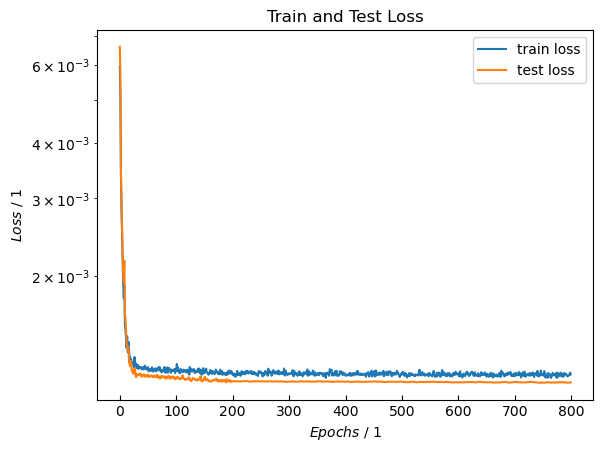

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Loss$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

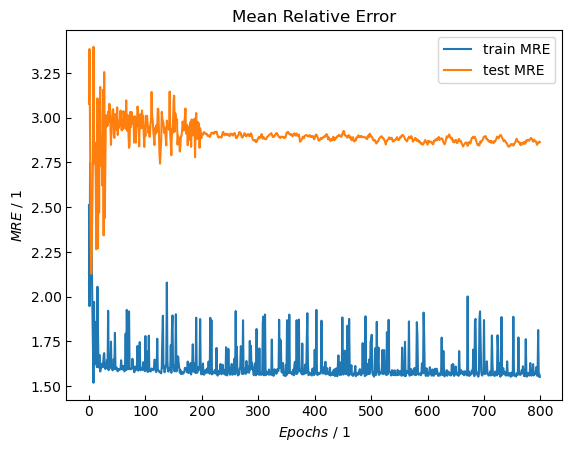

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

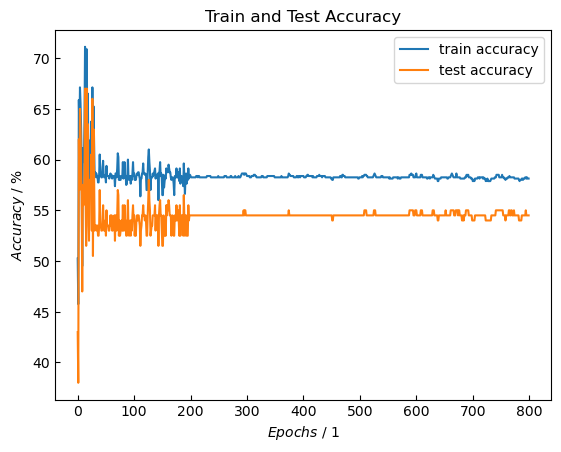

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

#### Debugging Hilfe

In [12]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[2.8895e+00, 1.9346e-01, 3.4035e-01, 3.2695e-01, 3.3270e-01],
        [2.9121e+00, 2.4731e-01, 1.7561e-01, 3.0300e-01, 5.2139e-01],
        [2.8431e+00, 1.1063e-01, 1.5887e-01, 5.4630e-01, 2.9483e-01],
        [2.9196e+00, 1.9858e-01, 3.8903e-01, 9.7260e-02, 5.1371e-01],
        [2.8190e+00, 1.7542e-01, 5.9980e-01, 3.2291e-01, 7.7288e-02],
        [2.9194e+00, 1.4293e-01, 1.9493e-01, 4.7480e-01, 3.3027e-01],
        [2.8234e+00, 1.3262e-01, 1.5324e-02, 4.5766e-02, 9.3891e-01],
        [2.9298e+00, 1.3751e-01, 1.8770e-01, 2.0795e-01, 6.0435e-01],
        [2.9120e+00, 1.2535e-01, 3.6349e-01, 4.0062e-01, 2.3589e-01],
        [2.9125e+00, 1.4461e-01, 2.3334e-02, 4.6445e-01, 5.1221e-01],
        [2.8855e+00, 2.4963e-01, 8.9502e-01, 1.7578e-03, 1.0322e-01],
        [2.8475e+00, 1.4382e-01, 6.7222e-01, 8.9779e-02, 2.3800e-01],
        [2.9190e+00, 1.8564e-01, 2.1313e-01, 4.8301e-01, 3.0386e-01],
        [2.8800e+00, 2.0612e-01, 1.4363e-01, 5.9676e-01, 2.5961e-01],
        [2.8707e+00,

#### Einblick in Netzwerk

In [13]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-1.5645e-01, -3.7037e-01, -3.9822e-02, -3.8814e-01,  1.2269e-01],
         [-3.0394e-01, -8.7447e-02, -2.0902e-01,  3.9799e-01, -2.1697e-01],
         [ 4.3916e-01,  3.0978e-01,  2.3668e-01, -2.1519e-01, -1.9150e-01],
         [-4.1724e-01, -1.9061e-01, -2.2749e-01, -2.3144e-01, -1.9238e-01],
         [-3.0372e-01,  4.5509e-02,  1.7116e-01, -6.6828e-02,  1.2777e-01],
         [-1.5903e-02,  2.0232e-02, -6.7050e-02,  4.4466e-01,  3.2233e-01],
         [-2.6536e-01, -3.7058e-01, -4.0500e-01,  3.3951e-01, -3.5260e-01],
         [-1.0226e-01,  1.9307e-01, -3.0876e-01, -2.5090e-01, -3.8565e-01],
         [ 1.7296e-01,  2.7675e-03,  2.1423e-01, -2.1113e-02, -2.3686e-01],
         [-2.8486e-01,  2.1598e-01,  3.8766e-01,  3.3555e-01,  1.1165e-01],
         [-1.4159e-02, -6.0634e-02,  4.2005e-02, -1.7351e-01,  4.0286e-01],
         [-3.9587e-01, -1.7136e-01, -3.4281e-02,  3.8550e-01, -3.2436e-01],
         [ 3.6283e-01,  4.0758e-01, -5.8121e-02, -3.1700e-01, -4.

In [14]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.2654, 0.8665, 0.4303, 0.0127, 0.4625],
        [0.7665, 0.4862, 0.4427, 0.5092, 0.5813]])
tensor([[0.0626],
        [0.0204]], grad_fn=<AddmmBackward0>)
